# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### План исследования

- Загрузка и предобработка данных. 
- Обучение модели, проверка работоспособности.
- Расчет потенциальной прибыли по регионам.
- Расчет потенциальной прибыли с отбором скважин.
- Оценка рисков.

### Сопроводительная информация о данных:

- Данные геологоразведки трёх регионов находятся в файлах
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Требования к расчёту прибыли:
- Предпочтительная модель -  линейная регрессия.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на регион — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Исходя из сопроводительной информации, данные по каждому региону находятся в отдельных файлах. Познакомимся с каждым, выясним, можно ли их объединять без предварительной подготовки данных.

In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
data1 = pd.read_csv("/datasets/geo_data_0.csv")
data2 = pd.read_csv("/datasets/geo_data_1.csv")
data3 = pd.read_csv("/datasets/geo_data_2.csv")

for i in range (1,4):
    print("".join(['data',str(i)]), 'info:\n')
    eval("".join(['data',str(i)])).info()
    print('\n',"".join(['data',str(i)])," head:\n")
    print(eval("".join(['data',str(i)])).head(),'\n')

data1 info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 data1  head:

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

data2 info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null

Данные однотипны. Пропусков нет. Типы данных приведены к соответствующим содержимому. Для целей знакомства с данными соединю в один датафрейм, присвоив индикатор региона соответствующим данным.

In [3]:
data = pd.DataFrame()

for i in range (1,4):
    eval("".join(['data',str(i)]))['region'] = i
    data = pd.concat([data, eval("".join(['data',str(i)]))])
print(data['region'].value_counts())
data.head()

1    100000
2    100000
3    100000
Name: region, dtype: int64


,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,1
1,2acmU,1.334711,-0.340164,4.365080,73.037750,1
2,409Wp,1.022732,0.151990,1.419926,85.265647,1
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,1
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,1


Проверим на дубликаты.

In [4]:
data.duplicated().sum()

0

Полные дубликаты отсутствуют, но возможно, есть повторяющиеся значения в поле ID

In [5]:
len(data['id'].unique())

299951

У нас есть 300 тысяч записей о скважинах, из них 49 неуникальны. Посмотрим на такие неуникальные строки: нужно ли их отбрасывать?

In [6]:
id_data = data['id'].value_counts().to_frame('count').rename_axis('id').reset_index()
non_unique = id_data[id_data['count'] > 1]['id'].tolist()

data.query('id in @non_unique').sort_values(by = 'id').head(16)

,id,f0,f1,f2,product,region
27380,2tyMi,-1.789602,-1.359044,-4.840745,145.901447,3
45429,2tyMi,0.576679,-0.411140,-3.725859,69.292672,1
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625,2
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044,2
72896,5ssQt,-0.651825,0.782415,2.690636,120.108761,3
16753,5ssQt,-1.005117,0.268726,-0.407822,53.206029,1
66136,74z30,1.084962,-0.312358,6.990771,127.643327,1
64022,74z30,0.741456,0.459229,5.153109,140.771492,1
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364,1
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205,1


Видно, что:  

а) одни и те же ID используются для разных регионов  
б) если ID использован дважды в одном регионе, значения неизвестных нам по смыслу параметров f0-f2 значительно отличаются.

Такие дубликаты не помешают анализу.

Посмотрим, видна ли наглядно корреляция объёма запасов в скважине с каким-либо из признаков f0-f2:

In [7]:
data.corr()['product']

f0        -0.030439
f1         0.137210
f2         0.533554
product    1.000000
region     0.021940
Name: product, dtype: float64

Видна заметная корреляция с показателем f2. Примем к сведению.  

Вероятно, для каждого отдельного региона эта картинка может выглядеть иначе. Посмотрим на них в отдельности.

In [8]:
for i in range (1,4):
    print(f'Регион {i}:')
    print(eval("".join(['data',str(i)])).corr().drop(['region','product'], axis = 0)['product'])
    print()

Регион 1:
f0    0.143536
f1   -0.192356
f2    0.483663
Name: product, dtype: float64

Регион 2:
f0   -0.030491
f1   -0.010155
f2    0.999397
Name: product, dtype: float64

Регион 3:
f0   -0.001987
f1   -0.001012
f2    0.445871
Name: product, dtype: float64



И впрямь: показатель f2 в регионе 2 максимально сильно коррелирует с итоговой отдачей каждой скважины. В регионах 1 и 2 корреляция есть, но умеренно выраженная.

Теперь посмотрим на f0-f2 более внимательно: стандартизованы ли они?

In [9]:
def feature_plot (data):
    f0 = data['f0']
    f1 = data['f1']
    f2 = data['f2']
    
    plt.hist(f0, alpha=0.7, label = 'f0')
    plt.hist(f1, alpha=0.7, label = 'f1')
    plt.hist(f2, alpha=0.7, label = 'f2')
    
    plt.grid()
    plt.legend(loc='upper right')

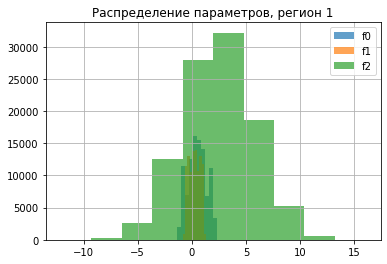

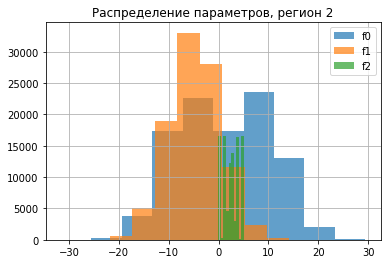

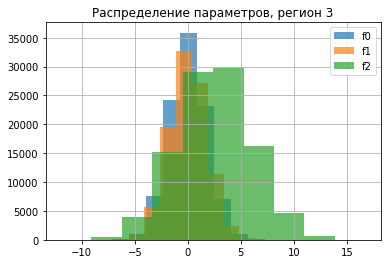

In [10]:
for i in range (1,4):
    feature_plot(eval(''.join(['data',str(i)])))
    plt.title(f"Распределение параметров, регион {i}")
    plt.show()

Можно заметить, что параметр f2 у региона 2, который показал наибольшую корреляцию с итоговой производительностью скважины, распределён в наименьшем диапазоне по сравнению с этим же параметром в остальных регионах, и гораздо более дискретно.

Теперь в рамках подготовки каждого из региональных датасетов к анализу отбросим колонки с id скважины и указателем региона, который мы добавляли для соединения данных в один массив. Признаки f0-f2 стоит привести к одному масштабу для устранения возможного влияния на модель.

data1 info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB




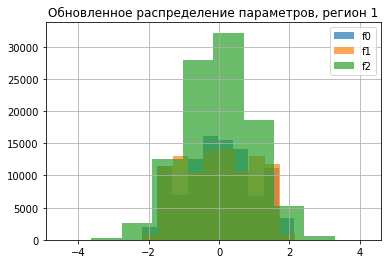

data2 info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB




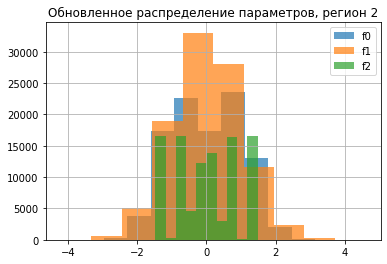

data3 info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB




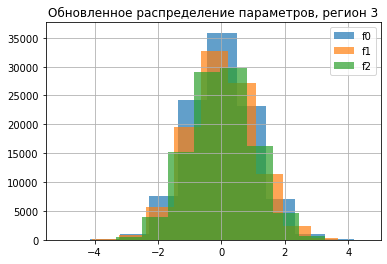

In [11]:
data1 = data1.drop(columns = ['id', 'region'])
data2 = data2.drop(columns = ['id', 'region'])
data3 = data3.drop(columns = ['id', 'region'])

features = ['f0','f1','f2']
scaler = StandardScaler()

for i in range (1,4):
    scaler.fit(eval(''.join(['data',str(i)]))[features]) 
    eval(''.join(['data',str(i)]))[features] = scaler.transform(eval(''.join(['data',str(i)]))[features])
    print("".join(['data',str(i)]), 'info:\n')
    eval("".join(['data',str(i)])).info()
    print('\n')
    feature_plot(eval(''.join(['data',str(i)])))
    plt.title(f"Обновленное распределение параметров, регион {i}")
    plt.show()

**Вывод:**  
Данные корректно собраны, признаки f0-f2 стандартизованы, данные подготовлены к дальнейшей работе.

## Обучение и проверка модели

Будем пользоваться только одной моделью, поэтому сразу сохраним её.

In [11]:
model = LinearRegression()

Для обучения модели и проверки её на каждом из регионов напишу соответствующую функцию.

In [12]:
def region_model(df):
    features = df.drop(columns = 'product')
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features,target,\
                                                                                  test_size=0.25,random_state=1234)

    model.fit(features_train, target_train)
    trained_model = model
    predictions = model.predict(features_valid)

    rmse_data = mean_squared_error(target_valid, predictions)** 0.5
    
    return target_valid, predictions, rmse_data, trained_model

Теперь применим её к каждому региону.

In [13]:
target1, prediction1, rmse1, model1 = region_model(data1)
target2, prediction2, rmse2, model2 = region_model(data2)
target3, prediction3, rmse3, model3 = region_model(data3)

for i in range (1,4):
    print(f"Регион {i}:")
    print(f"Средний рассчитанный объём добычи = {eval(''.join(['prediction',str(i)])).mean():.2f}, RMSE = {eval(''.join(['rmse',str(i)])):.2f}\n") 

Регион 1:
Средний рассчитанный объём добычи = 92.43, RMSE = 37.56

Регион 2:
Средний рассчитанный объём добычи = 68.80, RMSE = 0.89

Регион 3:
Средний рассчитанный объём добычи = 94.92, RMSE = 40.10



**Вывод:**  
Модель обучена, наиболее точные предсказания - для региона 2.

## Подготовка к расчёту прибыли

Зафиксируем ключевые параметры для принятия решения о разработке.

In [14]:
EXPLORED = 500 
DEVELOPED = 200
BUDGET = 10_000 # в млн. руб.
BARREL_PRICE = 0.45 # в млн. руб.
ACCEPTABLE_RISK = 0.025

Подсчитаем порог безубыточности.

In [15]:
BREAKEVEN_POINT = BUDGET/DEVELOPED/BARREL_PRICE
print (f'Минимальное пороговое значение для безубыточности добычи - {BREAKEVEN_POINT:.2f} тыс. баррелей')

Минимальное пороговое значение для безубыточности добычи - 111.11 тыс. баррелей


Сравним с предполагаемым средним запасом в каждом из регионов.

In [16]:
for i in range (1,4):
    print(f"Регион {i}:")
    print(f"Средний рассчитанный объём добычи = {eval(''.join(['prediction',str(i)])).mean():.2f}, RMSE = {eval(''.join(['rmse',str(i)])):.2f}")
    if eval(''.join(['prediction',str(i)])).mean() < BREAKEVEN_POINT:
        print (f"Средний запас меньше, чем пороговое значение {BREAKEVEN_POINT:.2f} \n")
    elif eval(''.join(['prediction',str(i)])).mean() > BREAKEVEN_POINT:
        print (f"Средний запас больше, чем пороговое значение {BREAKEVEN_POINT:.2f}\n")
    else: 
        print (f"Средний запас равен пороговому значению \n")

Регион 1:
Средний рассчитанный объём добычи = 92.43, RMSE = 37.56
Средний запас меньше, чем пороговое значение 111.11 

Регион 2:
Средний рассчитанный объём добычи = 68.80, RMSE = 0.89
Средний запас меньше, чем пороговое значение 111.11 

Регион 3:
Средний рассчитанный объём добычи = 94.92, RMSE = 40.10
Средний запас меньше, чем пороговое значение 111.11 



**Вывод:**  
Выбор 200 случайных скважин для разработки не подойдет ни в одном из регионов. Требуется более глубокий расчёт с учетом потенциальной отдачи каждой скважины.

## Расчёт прибыли и рисков 

Напишем функцию для подсчета прибыли при выборе N наиболее благоприятных скважин.

In [17]:
def profit (target, prediction, n, budget = BUDGET):
    prediction_sorted = prediction.sort_values(ascending=False) 
    selected = target[prediction_sorted.index][:n]
    revenue = BARREL_PRICE * selected.sum()
    profit = revenue - budget
    return profit

Теперь напишем функцию, которая, применяя бутстрэп, будет считать прибыль по региону и определять риски.

In [18]:
def region_assessment(target, predictions):
    predictions = pd.Series(predictions)
    profit_values = []

    state = np.random.RandomState(1234)
    
    for i in range(1000):
        target_subs = target.reset_index(drop=True).sample(n=EXPLORED, replace=True, random_state=state)
        pred_subs = predictions[target_subs.index]
        value = profit(target_subs, pred_subs, DEVELOPED)
        profit_values.append(value)
        
    profit_values = pd.Series(profit_values)
    risk = profit_values.where(profit_values >= 0).isna().sum()/len(profit_values)

    # считаем доверительный интервал
    lower = profit_values .quantile(0.025)
    upper = profit_values .quantile(0.975)

    # выводим результат
    print(f"Средняя прибыль в регионе: {profit_values .mean():.2f} млн. руб")
    print(f"95% доверительный интервал: {lower:.2f} - {upper:.2f} млн. руб. ")
    print(f"Риск убытков: {risk:.2%} vs. {ACCEPTABLE_RISK:.2%}")

    # сравниваем с необходимым риском
    if risk <= ACCEPTABLE_RISK:
          print('Риск убытков приемлем.')
    else:
          print('Риск убытков неприемлем.') 
    print("")      

Применим её на трёх наших регионах.

In [19]:
for i in range (1,4):
    print(f"Регион {i}:")
    region_assessment(eval(''.join(['target',str(i)])),eval(''.join(['prediction',str(i)])))

Регион 1:
Средняя прибыль в регионе: 408.94 млн. руб
95% доверительный интервал: -116.36 - 961.05 млн. руб. 
Риск убытков: 6.20% vs. 2.50%
Риск убытков неприемлем.

Регион 2:
Средняя прибыль в регионе: 489.60 млн. руб
95% доверительный интервал: 57.43 - 940.07 млн. руб. 
Риск убытков: 1.20% vs. 2.50%
Риск убытков приемлем.

Регион 3:
Средняя прибыль в регионе: 375.96 млн. руб
95% доверительный интервал: -207.76 - 962.53 млн. руб. 
Риск убытков: 8.30% vs. 2.50%
Риск убытков неприемлем.



## Общий вывод.

* Предоставленные данные были проанализированы.
* Была обучена модель линейной регрессии, получены предсказания.
* На основе предсказаний были оценены потенциальные перспективы по каждому из регионов.
* Наиболее перспективный регион для разработки - регион 2: он единственный предполагает приемлемый уровень риска убытков.